In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from pathlib import Path
from os.path import join

In [2]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(6, 12, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(12, 4, kernel_size = 3, padding = 1)

        self.upsample = nn.PixelShuffle(upscale_factor = 2)

    def forward(self, xb):
        
        xb = torch.tanh(self.conv1(xb))
        xb = torch.tanh(self.conv2(xb))
        xb = torch.sigmoid(self.conv3(xb))       

        return self.upsample(xb)

In [3]:
model_1 = torch.load("SR_model_1_1.0.ml")
model_2 = torch.load("SR_model_2_1.0.ml")
model_3 = torch.load("SR_model_3_1.0.ml")

In [4]:
bs = 4
workers = 4
ngpu = 1
output_path = "output/pred_imgs"

Path(output_path).mkdir(parents=True, exist_ok=True)

path_valid_x = "images/valid/valid_x"

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imgs_valid_x = datasets.ImageFolder(path_valid_x, transform = transform)

In [6]:
imgs_valid_x_dl = DataLoader(imgs_valid_x, batch_size = bs, num_workers = workers)

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [8]:
def save_images(i, pred_sr):
    for j, img in enumerate(pred_sr):
        img *= 255
        img = torch.round(img)
        filename = str(bs*i + j+1).zfill(5) + ".png"
        save_image(img, join(output_path, filename))
    

In [9]:
model_1 = model_1.to(device)
model_2 = model_2.to(device)
model_3 = model_3.to(device)

In [10]:
i = 0
for xb, _ in imgs_valid_x_dl:
    xb = xb.to(device)
    
    imgs_sr_1 = model_1(xb[:,0].unsqueeze(1))
    imgs_sr_2 = model_2(xb[:,1].unsqueeze(1))
    imgs_sr_3 = model_3(xb[:,2].unsqueeze(1))
    
    imgs_sr = torch.cat((imgs_sr_1, imgs_sr_2, imgs_sr_3), 1)
    
    save_images(i, imgs_sr)
    i += 1
    

In [11]:
pred_imgs_fd = datasets.ImageFolder("output", transform = transform)
pred_imgs_dl = DataLoader(pred_imgs_fd, batch_size = bs, num_workers = workers)
iter_pred_imgs = iter(pred_imgs_dl)
imgs, _ = iter_pred_imgs.next()

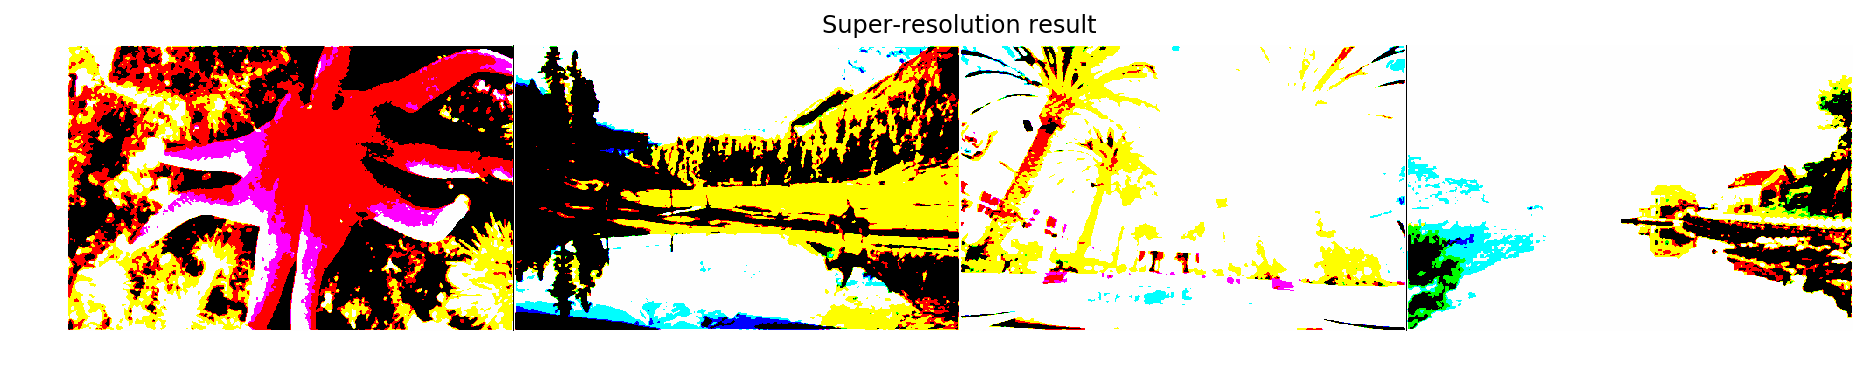

In [12]:
grid_img = vutils.make_grid(imgs, nrow=4, padding=1, normalize=True)
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Super-resolution result")
plt.imshow(grid_img.permute(1, 2, 0))
#plt.imshow(np.transpose(vutils.make_grid(imgs_big.to(device)[:8], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>